<a href="https://colab.research.google.com/github/sw2703/neural_style_transfer/blob/master/neural_style_transfer_vgg_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import tensorflow as tf

# Transfer Learning

In [2]:
model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(300, 400, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
print(model.summary())

80142336/80134624 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 400, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 200, 128)     147584    
______________________________________________________________

# Neural Style Transfer

## Compute the content cost

In [4]:
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!wget --quiet -P /tmp/nst/ https://photos.app.goo.gl/U9yxheYwufiQxH8H6

In [19]:
def compute_content_cost(a_C, a_G):
  """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (m, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (m, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
  """
  # Retrieve dimensions from a_G.
  m, n_H, n_W, n_C = a_G.get_shape().as_list()

  # Unroll a_C and a_G.
  a_C_unrolled = tf.reshape(a_C, [m, n_H * n_W, n_C])
  a_G_unrolled = tf.reshape(a_G, [m, n_H * n_W, n_C])

  # Compute the content cost.
  J_content = 1 / (4*n_H*n_W*n_C) * tf.reduce_sum(tf.square(a_C_unrolled-a_G_unrolled))

  return J_content

In [31]:
tf.random.set_seed(1)
a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_content = compute_content_cost(a_C, a_G)
print("J_content = " + str(J_content.numpy()))

J_content = 7.056877


## Compute the style cost

In [22]:
def gram_matrix(A):
  """
  Argument:
  A -- matrix of shape (n_C, n_H*n_W)
  
  Returns:
  GA -- Gram matrix of A, of shape (n_C, n_C)
  """
  return tf.matmul(A, tf.transpose(A))

In [26]:
tf.random.set_seed(1)
A = tf.random.normal([3, 2*1], mean=1, stddev=4)
GA = gram_matrix(A)

print("GA = \n" + str(GA.numpy()))

GA = 
[[ 63.1888    -26.721275   -7.7320204]
 [-26.721275   12.76758    -2.5158243]
 [ -7.7320204  -2.5158243  23.752384 ]]


In [34]:
def compute_layer_style_cost(a_S, a_G):
  """
  Arguments:
  a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
  a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
  
  Returns: 
  J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
  """  
  m, n_H, n_W, n_C = a_S.shape
  assert m==1
  a_S_unrolled = tf.reshape(a_S, [n_H*n_W, n_C]) 
  a_S_unrolled = tf.transpose(a_S_unrolled)
  a_G_unrolled = tf.reshape(a_G, [n_H*n_W, n_C]) 
  a_G_unrolled = tf.transpose(a_G_unrolled)
  return 1/(4*n_C**2*n_H**2*n_W*2) * tf.reduce_sum(
      tf.square(gram_matrix(a_S_unrolled) - gram_matrix(a_G_unrolled)))

In [35]:
tf.random.set_seed(1)
a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_style_layer = compute_layer_style_cost(a_S, a_G)

print("J_style_layer = " + str(J_style_layer.numpy()))

J_style_layer = 28.035616


In [36]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [38]:
def compute_style_cost(model, STYLE_LAYERS):
  """
  Computes the overall style cost from several chosen layers
  
  Arguments:
  model -- our tensorflow model
  STYLE_LAYERS -- A python list containing:
                      - the names of the layers we would like to extract style from
                      - a coefficient for each of them
  
  Returns: 
  J_style -- tensor representing a scalar value, style cost defined above by equation (2)
  """ 
  J_style = 0 
  for layer, coef in STYLE_LAYERS:
    a_S = model[layer].numpy()
    a_G = model[layer]
    J_style += coef * compute_layer_style_cost(a_S, a_G)
  return J_style

In [39]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
  """
  Computes the total cost function
  
  Arguments:
  J_content -- content cost coded above
  J_style -- style cost coded above
  alpha -- hyperparameter weighting the importance of the content cost
  beta -- hyperparameter weighting the importance of the style cost
  
  Returns:
  J -- total cost as defined by the formula above.
  """
  return alpha*J_content + beta*J_style

In [42]:
np.random.seed(3)
J_content = np.random.randn()    
J_style = np.random.randn()
J = total_cost(J_content, J_style)
print("J = " + str(J))

J = 35.34667875478276


# Solving the optimization problem

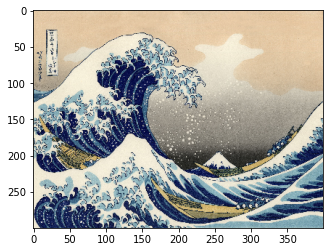

In [57]:
content_image = plt.imread('/tmp/nst/The_Great_Wave_off_Kanagawa.jpg')
content_image = tf.image.resize(content_image, size=[300, 400])/256
plt.imshow(content_image)